In [1]:
import src
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats

plt.rcParams.update({
    "font.size": 10,
    "figure.dpi": 100,
})

%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
HOME_DIR, BASE_DIR, CODE_DIR, TB_DIR, RMS_DATA_DIR = src.config.config_paths()

In [4]:
def _smooth(sig, win=11):
    """
    Smooth signal using a moving average filter.

    Replicates MATLAB's smooth function. (http://tinyurl.com/374kd3ny)

    Args:
        sig (np.array): Signal to smooth.
        win (int, optional): Window size. Defaults to 11.

    Returns:
        np.array: Smoothed signal.
    """
    out = np.convolve(sig, np.ones(win, dtype=int), 'valid') / win
    r = np.arange(1, win - 1, 2)
    start = np.cumsum(sig[:win - 1])[::2] / r
    stop = (np.cumsum(sig[:-win:-1])[::2] / r)[::-1]
    return np.concatenate((start, out, stop))

In [42]:
expLabels = [
    'Test 11',
    'Test 14',
    'Test 15',
    'Test 16',
    'Test 17',
    'Test 18',
    'Test 19',
    'Test 21',
    'Test 22',
    'Test 23',
    'Test 24',
    'Test 25',
    'Test 26',
    'Test 28',
    'Test 30',
    'Test 31',
]

exps = [src.load(label) for label in expLabels]

for exp in exps:
    exp.features.loc[:,['Form error', 'Runout']] = exp.features.loc[:, ['Form error', 'Runout']]*1000

In [43]:
dfs = [exp.features.copy() for exp in exps]

In [44]:
data_names = ['mean_radius', 'peak_radius', 'runout', 'form_error']

m_rad = [exp.nc4.mean_radius for exp in exps]
p_rad = [exp.nc4.peak_radius for exp in exps]
runout = [exp.nc4.runout for exp in exps]
form_error = [exp.nc4.form_error for exp in exps]

data = [m_rad, p_rad, runout, form_error]

In [45]:
probe_doc = [exp.features['Probe diff'].iloc[1:] for exp in exps]
win = 5
if win > 1:
    probe_doc = [_smooth(d, win) for d in probe_doc]

C:\Users\tomje\AppData\Local\Temp\ipykernel_28216\293677219.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  start = np.cumsum(sig[:win - 1])[::2] / r
C:\Users\tomje\AppData\Local\Temp\ipykernel_28216\293677219.py:17: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  stop = (np.cumsum(sig[:-win:-1])[::2] / r)[::-1]


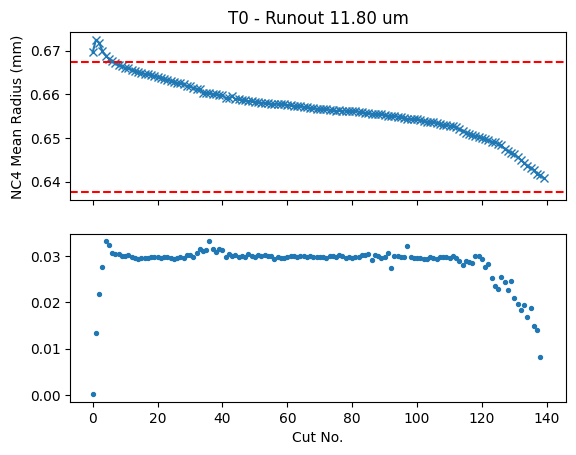

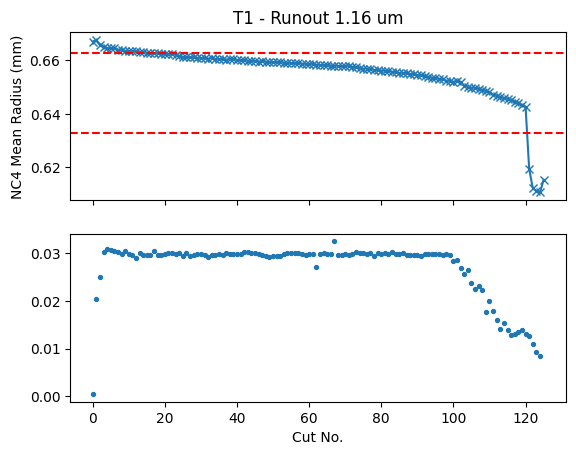

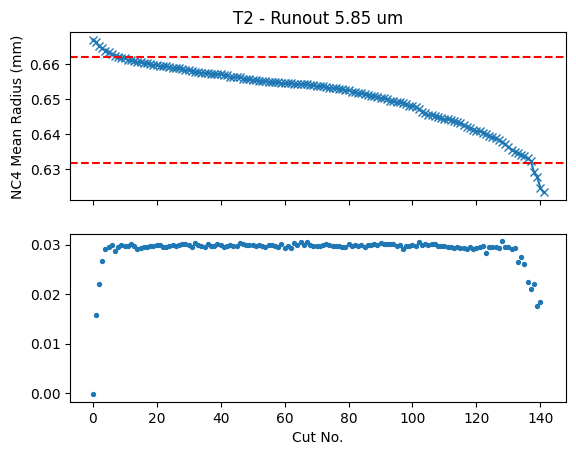

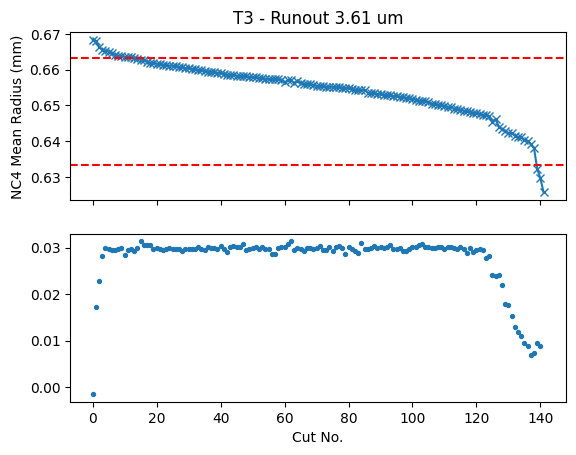

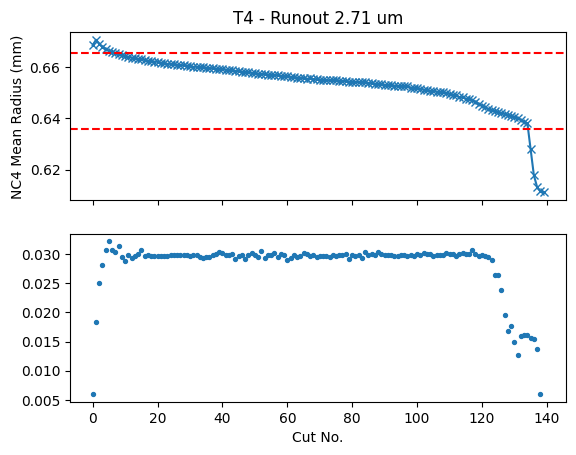

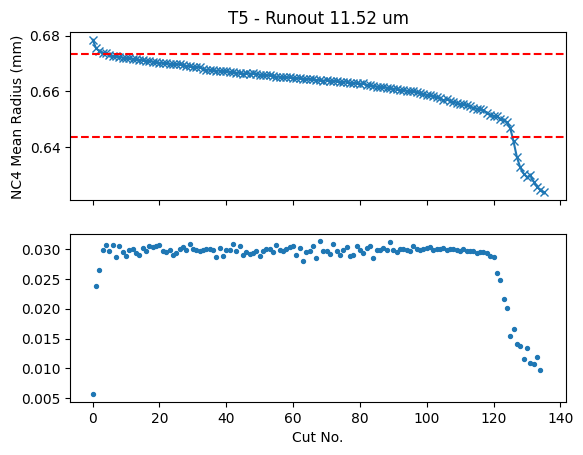

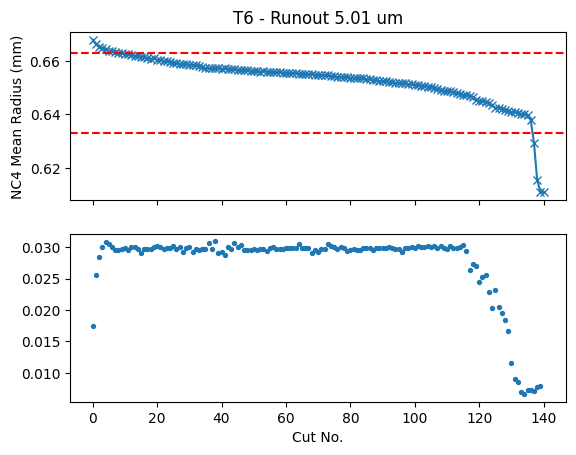

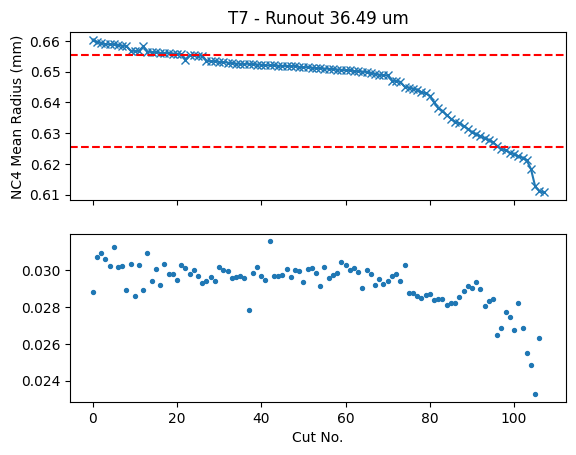

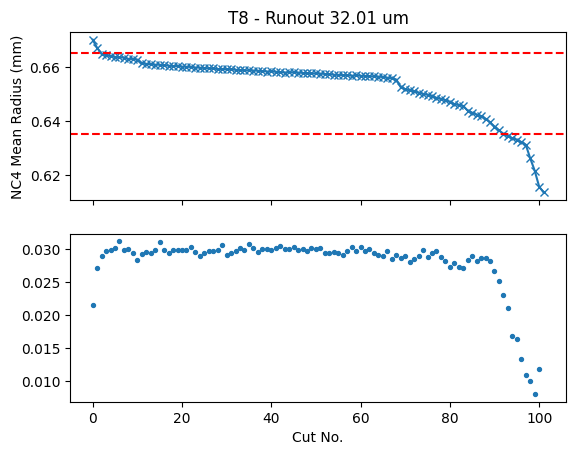

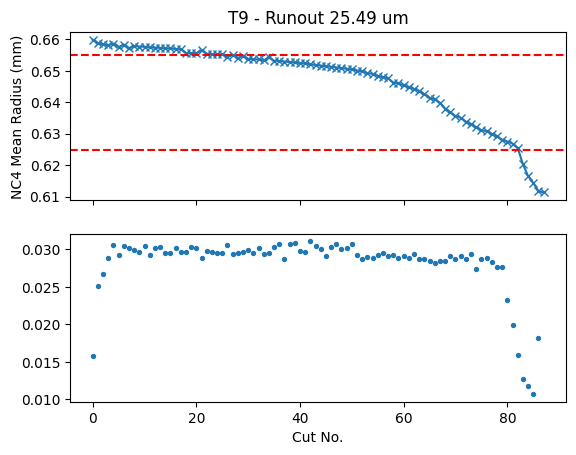

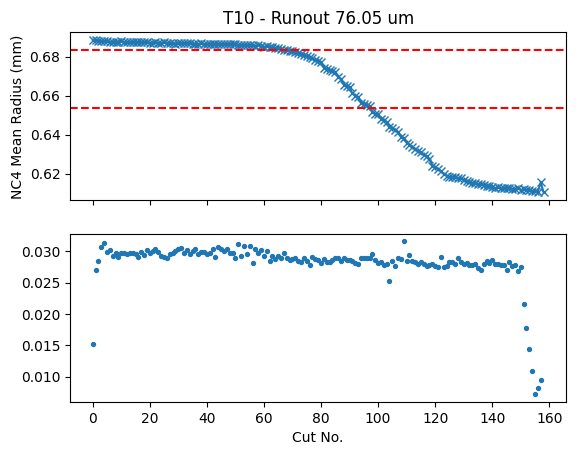

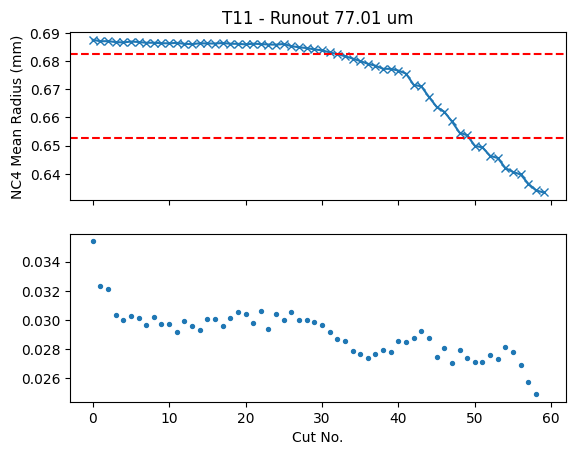

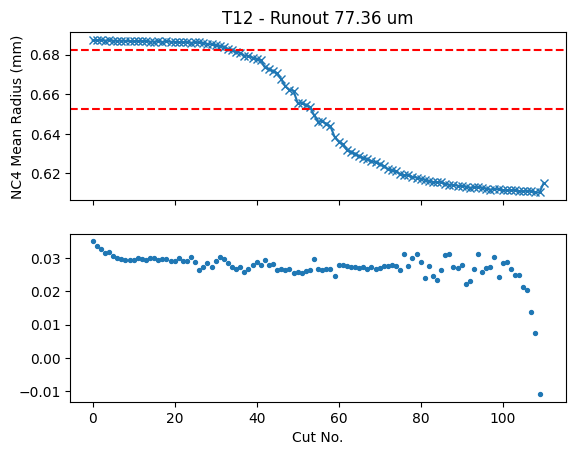

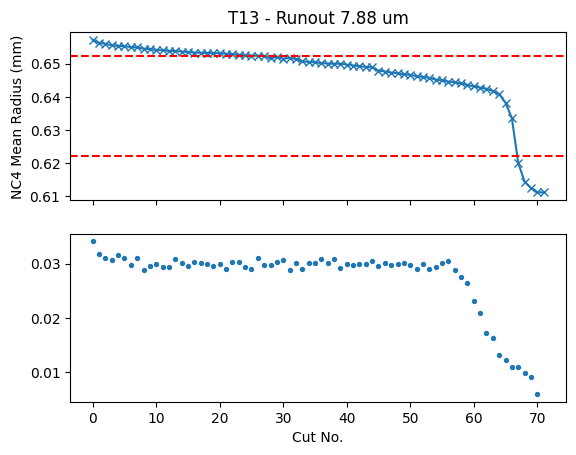

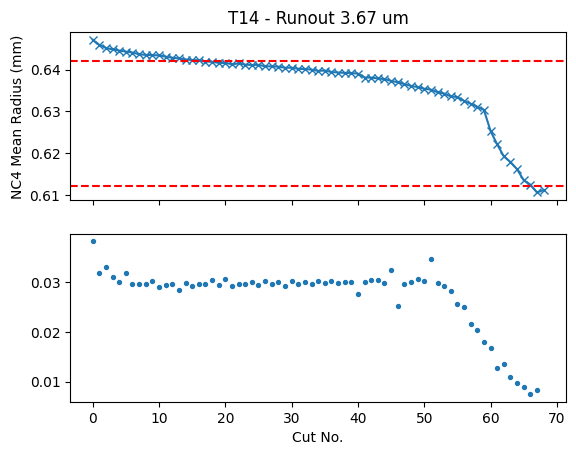

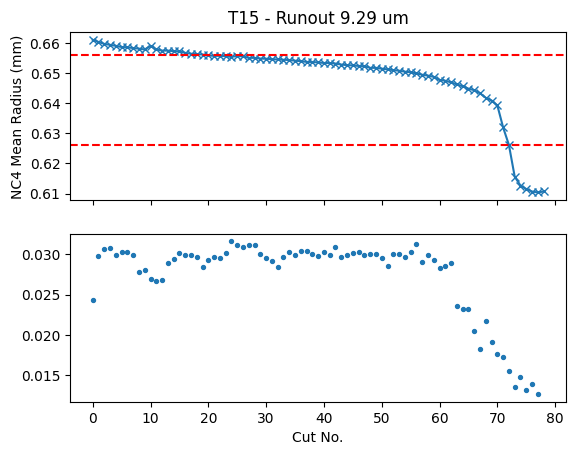

In [57]:
for ix in range(len(exps)):
    fig, ax = plt.subplots(2, 1, sharex=True,)

    mrad = m_rad[ix]
    probe = probe_doc[ix]

    ax[0].plot(range(len(mrad)), mrad, 'x-')

    wearinpoint = np.max(mrad) - 0.005
    ax[0].axhline(y=wearinpoint, color='r', linestyle='--')

    wearoutpoint = np.max(mrad) - 0.035
    ax[0].axhline(y=wearoutpoint, color='r', linestyle='--')

    cr = np.argmax(mrad < wearinpoint)

    ax[0].set_title(f'T{ix} - Runout {runout[ix][0] * 1000:.2f} um')
    # ax[0].set_xlim(-1, len(m_rad))
    ax[1].set_xlabel('Cut No.')
    ax[0].set_ylabel('NC4 Mean Radius (mm)')

    ax[1].scatter(range(len(probe)), probe, s=8)

In [ ]:
for ix in range(len(exps)):

    fig, ax = plt.subplots()

    mrad = m_rad[ix]
    ax.plot(mrad)

    grad = np.diff(mrad)
    grad = np.insert(grad, 0, np.NaN)
    grad = np.abs(grad)

    # orange
    threshold = 0.0006
    crossings = np.where(grad >= threshold)[0]
    mask = np.zeros_like(mrad)
    mask[crossings] = 1
    for cr in crossings:
        mask[cr-1] = 1
    mrad_mask = np.ma.masked_where(mask == 0, mrad)
    ax.plot(mrad_mask, 'C1')

    # red
    threshold = 0.001
    crossings = np.where(grad >= threshold)[0]
    mask = np.zeros_like(mrad)
    mask[crossings] = 1
    for cr in crossings:
        mask[cr-1] = 1
    mrad_mask = np.ma.masked_where(mask == 0, mrad)
    ax.plot(mrad_mask, 'r')

    ax.set_title(f'T{ix}')
    ax.set_xlim(-1, len(m_rad[ix]))
    ax.set_xlabel('Cut No.')
    ax.set_ylabel('NC4 Mean Radius (mm)')

In [ ]:
crossing_ix = []

for ix in range(len(exps)):
    fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

    ax[0].plot(m_rad[ix])
    ax[1].scatter(np.arange(1, len(m_rad[ix])), probe_doc[ix], s=5)

    mrad = m_rad[ix]
    win = 11
    # mrad = _smooth(mrad, win) 
    grad = np.diff(mrad)
    grad = np.insert(grad, 0,np.NaN)
    grad = np.abs(grad)

    ax[2].plot(grad)

    threshold = 0.0006
    ax[2].axhline(threshold, color='r', linestyle='--')
    # crossing point where gradient is less than threshold and negative
    # try:
    #     crossing = np.where(grad[10:] < threshold)[0][0]
    #     crossing = crossing + 10
    #     crossing_ix.append(crossing)
    #     ax[2].axvline(crossing - 1, color='r', linestyle='--')
    #     ax[1].axvline(crossing - 1, color='r', linestyle='--')
    #     ax[0].axvline(crossing -1, color='r', linestyle='--')
    # except IndexError:
    #     pass
    crossings = np.where(grad >= threshold)[0]
    crossing_ix.append(crossings)
    for crossing in crossings:
        ax[2].axvline(crossing, color='r', linestyle='--')
        ax[1].axvline(crossing, color='r', linestyle='--')
        ax[0].axvline(crossing, color='r', linestyle='--')

    ax[0].set_title(f'T{ix} - THRESHOLD IX: {crossing}')
    ax[0].set_xlim(-1, len(m_rad[ix]))
    ax[2].set_xlabel('Cut No.')
    ax[1].set_ylabel('Probe Diff (mm)')
    ax[2].set_ylabel('Mean radius gradient')
    ax[0].set_ylabel('NC4 Mean Radius (mm)')

In [ ]:
for i, exp in enumerate(exps):
    fig, ax = plt.subplots()
    r = np.array(exp.nc4.radius, dtype=float)
    x = np.array(exp.nc4.theta, dtype=float)
    y = np.array(exp.nc4._datano, dtype=float)
    surf = ax.pcolormesh(x,
                            y,
                            r,
                            cmap='jet',
                            rasterized=True,
                            shading='nearest',
                            )
    for cr in crossing_ix[i]:
        ax.axhline(cr, color='r', linestyle='--', linewidth=1, alpha=0.5)

    fig.suptitle(f'T{i}')
    ax.set_xlabel('Angle (rad)')
    ax.set_ylabel('Measurement No.')
    fig.tight_layout()